# Nonlinear heat PDE

Diffrax can also be used to solve some PDEs.

(Specifically, the scope of Diffrax is "any numerical method which iterates over timesteps". This means that e.g. semidiscretised evolution equations are in-scope, but e.g. finite volume methods for elliptic equations are out-of-scope.)

---

In this example, we solve the nonlinear heat equation

$$ \frac{\partial y}{\partial t}(t, x) = (1 - y(t, x)) \Delta y(t, x) \qquad\text{in}\qquad t \in [0, 40], x \in [-1, 1]$$

subject to the initial condition

$$ y(0, x) = x^2, $$

and Dirichlet boundary conditions

$$ y(t, -1) = 1,\qquad y(t, 1) = 1. $$

---

We spatially discretise $x \in [-1, 1]$ into points $-1 = x_0 < x_1 < \cdots < x_{n-1} = 1$, with equal spacing $\delta x = x_{i+1} - x_i$. The solution is then discretised into $y(t, x_i) \approx y_i(t)$, and the Laplacian discretised into $\Delta y(t,x_i) \approx \frac{y_{i+1}(t) - 2y_{i}(t) + y_{i-1}(t)}{\delta x^2}$.

In doing so we reduce to a system of ODEs

$$ \frac{\mathrm{d}y_i}{\mathrm{d}t}(t) = (1 - y_i(t)) \frac{y_{i+1}(t) - 2y_{i}(t) + y_{i-1}(t)}{\delta x^2} \qquad\text{for}\qquad i \in \{1, ..., n-2\},$$

subject to the initial condition

$$ y_i(0) = {x_i}^2, $$

for which the Dirichlet boundary conditions become

$$ \frac{\mathrm{d}y_0}{\mathrm{d}t}(t) = 0,\qquad \frac{\mathrm{d}y_{n-1}}{\mathrm{d}t}(t) = 0. $$

---

This example is available as a Jupyter notebook [here](https://github.com/patrick-kidger/diffrax/blob/main/examples/nonlinear_heat_pde.ipynb).


!!! danger "Advanced example"

    This is an advanced example, as it involves defining a custom solver.

In [1]:
from typing import Callable

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.lax as lax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jaxtyping import Array, Float  # https://github.com/google/jaxtyping


jax.config.update("jax_enable_x64", True)

In [2]:
# Represents the interval [x0, x_final] discretised into n equally-spaced points.
class SpatialDiscretisation(eqx.Module):
    x0: float = eqx.field(static=True)
    x_final: float = eqx.field(static=True)
    vals: Float[Array, "n"]

    @classmethod
    def discretise_fn(cls, x0: float, x_final: float, n: int, fn: Callable):
        if n < 2:
            raise ValueError("Must discretise [x0, x_final] into at least two points")
        vals = jax.vmap(fn)(jnp.linspace(x0, x_final, n))
        return cls(x0, x_final, vals)

    @property
    def δx(self):
        return (self.x_final - self.x0) / (len(self.vals) - 1)

    def binop(self, other, fn):
        if isinstance(other, SpatialDiscretisation):
            if self.x0 != other.x0 or self.x_final != other.x_final:
                raise ValueError("Mismatched spatial discretisations")
            other = other.vals
        return SpatialDiscretisation(self.x0, self.x_final, fn(self.vals, other))

    def __add__(self, other):
        return self.binop(other, lambda x, y: x + y)

    def __mul__(self, other):
        return self.binop(other, lambda x, y: x * y)

    def __radd__(self, other):
        return self.binop(other, lambda x, y: y + x)

    def __rmul__(self, other):
        return self.binop(other, lambda x, y: y * x)

    def __sub__(self, other):
        return self.binop(other, lambda x, y: x - y)

    def __rsub__(self, other):
        return self.binop(other, lambda x, y: y - x)


def laplacian(y: SpatialDiscretisation) -> SpatialDiscretisation:
    y_next = jnp.roll(y.vals, shift=1)
    y_prev = jnp.roll(y.vals, shift=-1)
    Δy = (y_next - 2 * y.vals + y_prev) / (y.δx**2)
    # Dirichlet boundary condition
    Δy = Δy.at[0].set(0)
    Δy = Δy.at[-1].set(0)
    return SpatialDiscretisation(y.x0, y.x_final, Δy)

First let's try solving this semidiscretisation directly, as a system of ODEs.

In [3]:
# Problem
def vector_field(t, y, args):
    return (1 - y) * laplacian(y)


term = diffrax.ODETerm(vector_field)
ic = lambda x: x**2

# Spatial discretisation
x0 = -1
x_final = 1
n = 50
y0 = SpatialDiscretisation.discretise_fn(x0, x_final, n, ic)

# Temporal discretisation
t0 = 0
t_final = 1
δt = 0.0001
saveat = diffrax.SaveAt(ts=jnp.linspace(t0, t_final, 50))

# Tolerances
rtol = 1e-10
atol = 1e-10
stepsize_controller = diffrax.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=0.001
)

In [4]:
solver = diffrax.Tsit5()
sol = diffrax.diffeqsolve(
    term,
    solver,
    t0,
    t_final,
    δt,
    y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

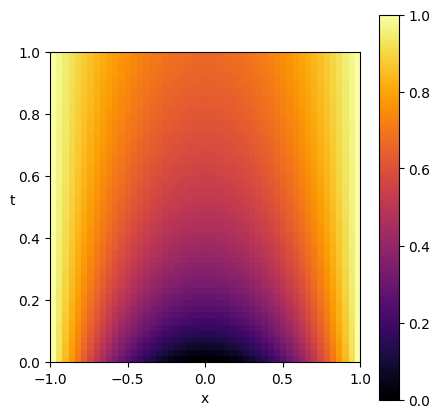

In [5]:
plt.figure(figsize=(5, 5))
plt.imshow(
    sol.ys.vals,
    origin="lower",
    extent=(x0, x_final, t0, t_final),
    aspect=(x_final - x0) / (t_final - t0),
    cmap="inferno",
)
plt.xlabel("x")
plt.ylabel("t", rotation=0)
plt.clim(0, 1)
plt.colorbar()
plt.show()

That worked!

However, for more complicated PDEs then we may wish to define a custom solver. So as an example, here's how to solve the same PDE using the famous [Crank–Nicolson](https://en.wikipedia.org/wiki/Crank%E2%80%93Nicolson_method) scheme.

(See the page on [abstract solvers](https://docs.kidger.site/diffrax/api/solvers/abstract_solvers/) for more details about how to define a custom solver.)

In [6]:
class CrankNicolson(diffrax.AbstractSolver):
    rtol: float
    atol: float

    term_structure = diffrax.ODETerm
    interpolation_cls = diffrax.LocalLinearInterpolation

    def order(self, terms):
        return 2

    def init(self, terms, t0, t1, y0, args):
        return None

    def step(self, terms, t0, t1, y0, args, solver_state, made_jump):
        del solver_state, made_jump
        δt = t1 - t0
        f0 = terms.vf(t0, y0, args)

        def keep_iterating(val):
            _, not_converged = val
            return not_converged

        def fixed_point_iteration(val):
            y1, _ = val
            new_y1 = y0 + 0.5 * δt * (f0 + terms.vf(t1, y1, args))
            diff = jnp.abs((new_y1 - y1).vals)
            max_y1 = jnp.maximum(jnp.abs(y1.vals), jnp.abs(new_y1.vals))
            scale = self.atol + self.rtol * max_y1
            not_converged = jnp.any(diff > scale)
            return new_y1, not_converged

        euler_y1 = y0 + δt * f0
        y1, _ = lax.while_loop(keep_iterating, fixed_point_iteration, (euler_y1, False))

        y_error = y1 - euler_y1
        dense_info = dict(y0=y0, y1=y1)

        solver_state = None
        result = diffrax.RESULTS.successful
        return y1, y_error, dense_info, solver_state, result

    def func(self, terms, t0, y0, args):
        return terms.vf(t0, y0, args)

In [7]:
solver = CrankNicolson(rtol=rtol, atol=atol)
sol = diffrax.diffeqsolve(
    term,
    solver,
    t0,
    t_final,
    δt,
    y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

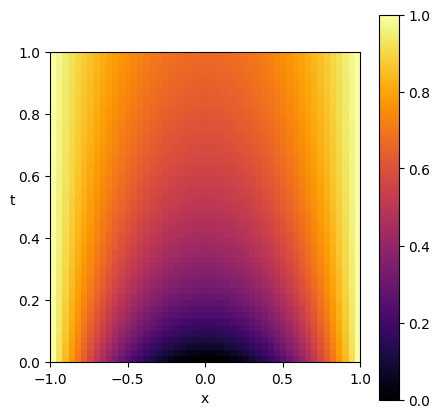

In [8]:
plt.figure(figsize=(5, 5))
plt.imshow(
    sol.ys.vals,
    origin="lower",
    extent=(x0, x_final, t0, t_final),
    aspect=(x_final - x0) / (t_final - t0),
    cmap="inferno",
)
plt.xlabel("x")
plt.ylabel("t", rotation=0)
plt.clim(0, 1)
plt.colorbar()
plt.show()

Some final notes.

1. We wrote down the general Crank–Nicolson method, which uses a fixed point iteration to solve the implicit problem. If you know something about the structure of your problem (e.g. that it is linear) then it is often possible to more specialised solvers, which run faster. (E.g. linear solvers.)

2. To keep this example brief, we didn't worry about doing a von Neumann stability analysis.